<a href="https://colab.research.google.com/github/1leilahm/O_M_SIM/blob/master/leila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/1leilahm/data

Cloning into 'data'...
remote: Enumerating objects: 2872, done.
remote: Counting objects: 100% (2872/2872), done.
remote: Compressing objects: 100% (2869/2869), done.
remote: Total 2872 (delta 3), reused 2872 (delta 3), pack-reused 0
Receiving objects: 100% (2872/2872), 35.40 MiB | 21.27 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
!ls data

driving_log.csv  IMG


In [3]:
!pip3 install imgaug

    100% |████████████████████████████████| 634kB 20.7MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
import cv2
from imgaug import augmenters as iaa
import pandas as pd
import ntpath
import random
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [5]:
datadir='data'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()



center  \
0  C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_00_669.jpg   
1  C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_00_755.jpg   
2  C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_00_842.jpg   
3  C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_00_931.jpg   
4  C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_01_014.jpg   

                                                                        left  \
0  C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_00_669.jpg   
1  C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_00_755.jpg   
2  C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_00_842.jpg   
3  C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_00_931.jpg   
4  C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_01_014.jpg   

                                                                        right  \
0  C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_00_669.jpg   
1  C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_00_755.jpg   
2  C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_00_842.jpg   
3  C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_00_931.jpg   
4  C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_01_014.jpg   

   steering  throttle  reverse         speed  
0  0.0       0.0       0        9.389272e-06  
1  0.0       0.0       0        1.434016e-06  
2  0.0       0.0       0        1.414957e-06  
3  0.0       0.0       0        4.546780e-07  
4  0.0       0.0       0        1.230139e-07

In [6]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()


center                              left  \
0  center_2018_11_15_21_17_00_669.jpg  left_2018_11_15_21_17_00_669.jpg   
1  center_2018_11_15_21_17_00_755.jpg  left_2018_11_15_21_17_00_755.jpg   
2  center_2018_11_15_21_17_00_842.jpg  left_2018_11_15_21_17_00_842.jpg   
3  center_2018_11_15_21_17_00_931.jpg  left_2018_11_15_21_17_00_931.jpg   
4  center_2018_11_15_21_17_01_014.jpg  left_2018_11_15_21_17_01_014.jpg   

                               right  steering  throttle  reverse  \
0  right_2018_11_15_21_17_00_669.jpg  0.0       0.0       0         
1  right_2018_11_15_21_17_00_755.jpg  0.0       0.0       0         
2  right_2018_11_15_21_17_00_842.jpg  0.0       0.0       0         
3  right_2018_11_15_21_17_00_931.jpg  0.0       0.0       0         
4  right_2018_11_15_21_17_01_014.jpg  0.0       0.0       0         

          speed  
0  9.389272e-06  
1  1.434016e-06  
2  1.414957e-06  
3  4.546780e-07  
4  1.230139e-07

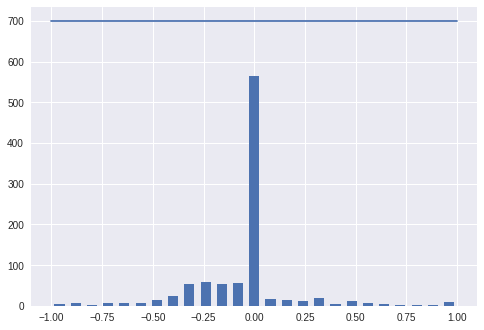

In [7]:
num_bins=25
samples_per_bin=700
hist,bins=np.histogram(data['steering'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data: 964
removed: 0
remaining: 964


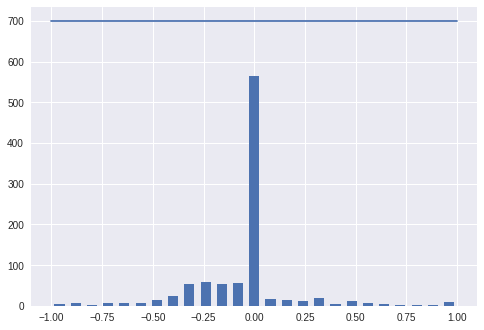

In [8]:
print('total data:',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
print(data.iloc[1])
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[3]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
    
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings
    
image_paths,steerings=load_img_steering(datadir+'/IMG',data)

center      center_2018_11_15_21_17_00_755.jpg
left        left_2018_11_15_21_17_00_755.jpg  
right       right_2018_11_15_21_17_00_755.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       1.43402e-06                       
Name: 1, dtype: object


In [10]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=5)
print('Training Samples : {}\nValid Samples : {}'.format(len(X_train),len(X_valid)))

Training Samples : 771
Valid Samples : 193


Text(0.5,1,'Validation set')

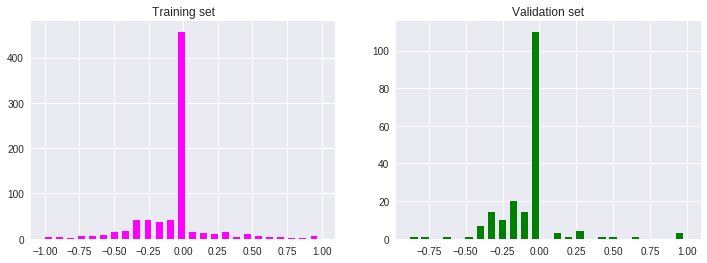

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='magenta')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='green')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5,1,'Zoomed Image')

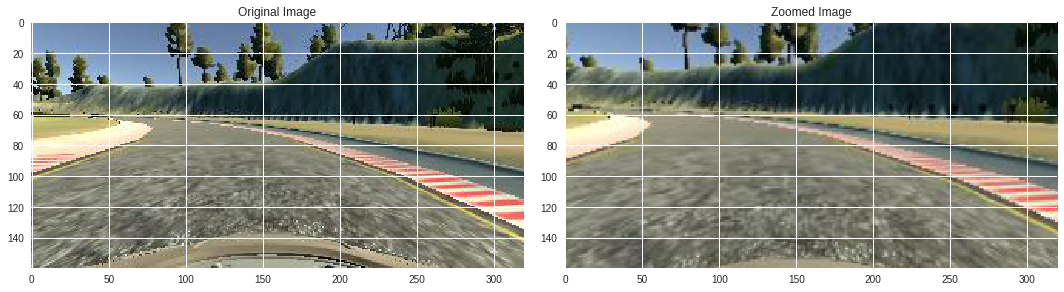

In [13]:
image=image_paths[random.randint(0,100)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5,1,'Panned image')

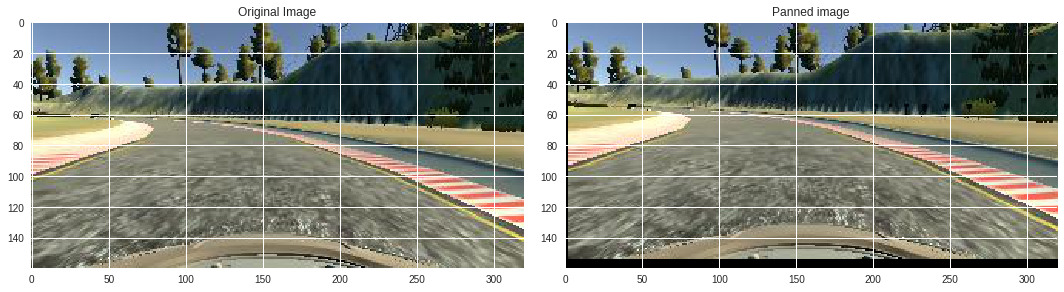

In [15]:
image=image_paths[random.randint(0,100)]
original_image=mpimg.imread(image)
panned_image=pan(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [0]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2,1.2))
  image=brightness.augment_image(image)
  return image

Text(0.5,1,'brightness_altered_image image')

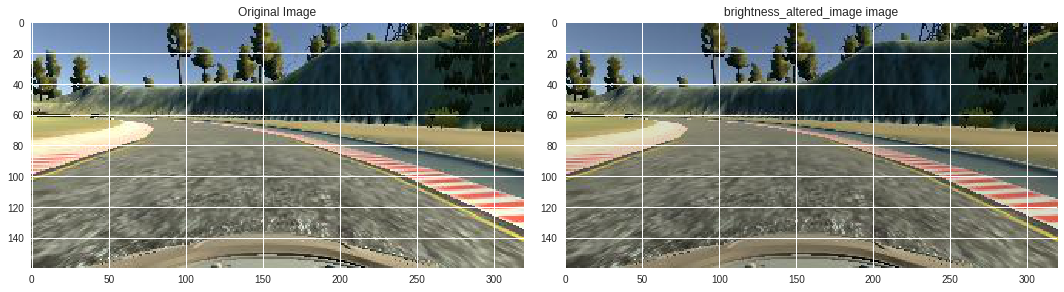

In [17]:
image=image_paths[random.randint(0,100)]
original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('brightness_altered_image image')

In [0]:
def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1)
  steering_angle=-steering_angle
  return image,steering_angle

Text(0.5,1,'Flipped Image - Steering Angle:-0.0')

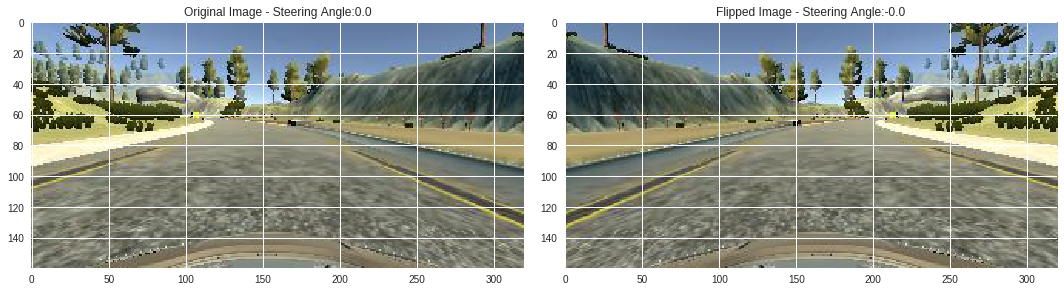

In [19]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]
original_image=mpimg.imread(image)
flipped_image,flipped_steering_angle=img_random_flip(original_image,steering_angle)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' +str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' +str(flipped_steering_angle))

In [0]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand()<0.5:
    image=img_random_brightness(image)
  if np.random.rand()<0.5:
    image,steering_angle=img_random_flip(image,steering_angle)
  return image,steering_angle

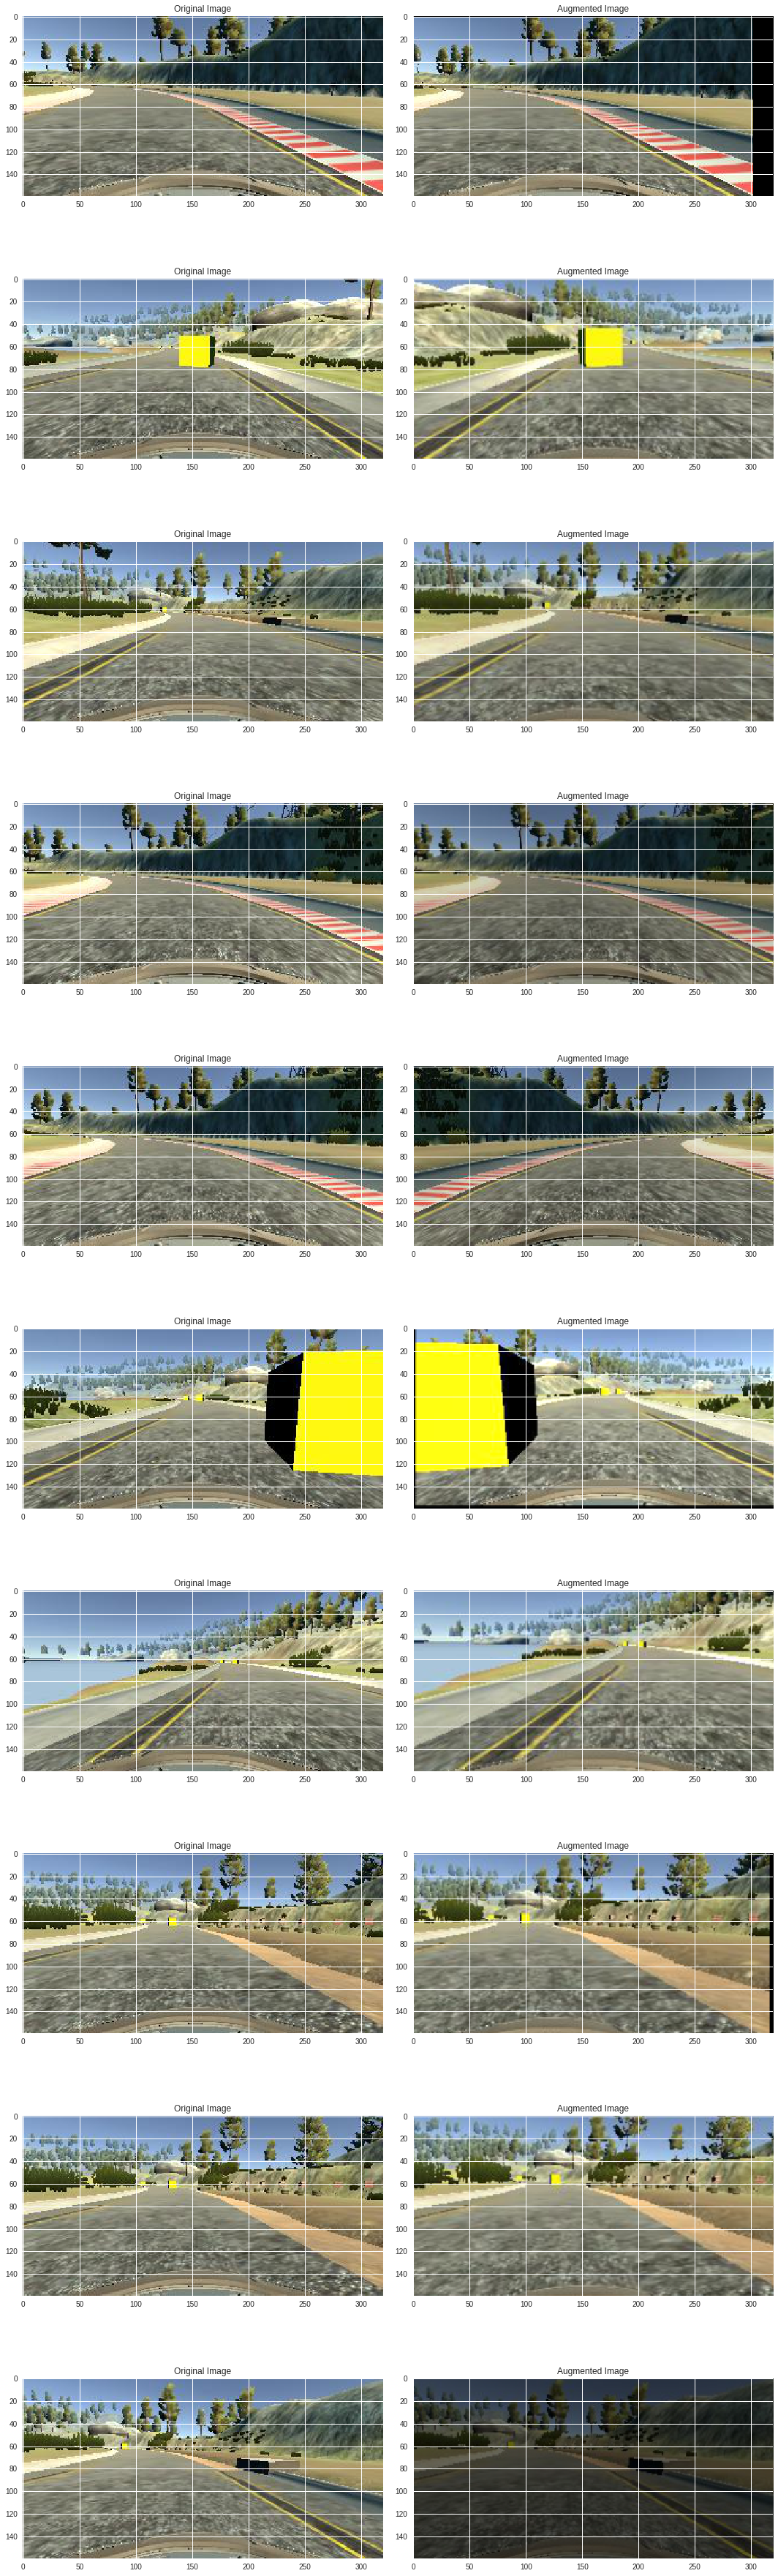

In [21]:
ncol=2
nrow=10
fig,axs=plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()
for i in range(10):
  randnum=random.randint(0,len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]
  original_image=mpimg.imread(random_image)
  augmented_image,steering=random_augment(random_image,random_steering)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [0]:
def img_preprocess(img):
  img=mpimg.imread(img)
  img=img[60:140,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

Text(0.5,1,'Preprocssed Image')

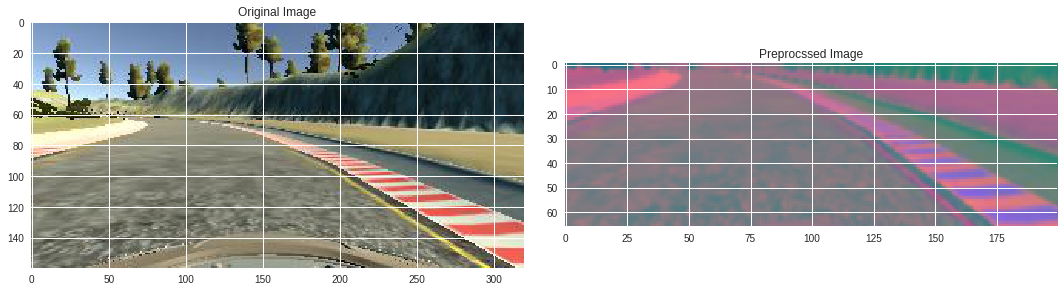

In [23]:
image = image_paths[100]
original_image=mpimg.imread(image)
preprocessed_image=img_preprocess(image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocssed Image')


In [0]:
X_train=np.array(list(map(img_preprocess,X_train)))
X_valid=np.array(list(map(img_preprocess,X_valid)))

(771, 66, 200, 3)


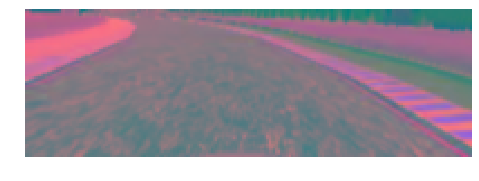

In [25]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:

def first_model():
  
  model=Sequential()
  model.add(Convolution2D(24,5,5,subsample=(2,2),input_shape=(66,200,3),activation='relu'))
  model.add(Convolution2D(36, 5, 5, activation='relu', subsample=(2, 2)))
  model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(2, 2)))
  model.add(Convolution2D(64, 3, 3, activation='relu'))
  model.add(Convolution2D(64, 3, 3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation='elu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3),metrics=['accuracy'])
  return model
  

In [27]:
model=first_model()
print (model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [28]:
history=model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),batch_size=100,verbose=1,shuffle=1)

Train on 771 samples, validate on 193 samples
Epoch 1/30
771/771 [==============================] - 5s 6ms/step - loss: 0.0777 - acc: 0.5785 - val_loss: 0.0486 - val_acc: 0.5596
Epoch 2/30
771/771 [==============================] - 1s 665us/step - loss: 0.0630 - acc: 0.5785 - val_loss: 0.0484 - val_acc: 0.5596
Epoch 3/30
771/771 [==============================] - 1s 652us/step - loss: 0.0620 - acc: 0.5785 - val_loss: 0.0487 - val_acc: 0.5596
Epoch 4/30
771/771 [==============================] - 1s 672us/step - loss: 0.0617 - acc: 0.5785 - val_loss: 0.0478 - val_acc: 0.5596
Epoch 5/30
771/771 [==============================] - 1s 677us/step - loss: 0.0604 - acc: 0.5785 - val_loss: 0.0452 - val_acc: 0.5596
Epoch 6/30
771/771 [==============================] - 1s 694us/step - loss: 0.0576 - acc: 0.5785 - val_loss: 0.0452 - val_acc: 0.5596
Epoch 7/30
771/771 [==============================] - 1s 695us/step - loss: 0.0512 - acc: 0.5772 - val_loss: 0.0392 - val_acc: 0.5596
Epoch 8/30
771/771

Text(0.5,0,'Epoch')

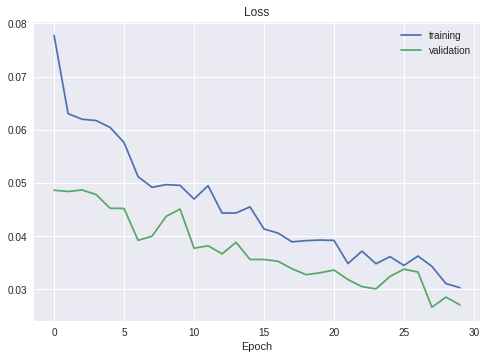

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
y_pred = model.predict(X_valid)

In [31]:
y_pred[:5]

array([[-0.09859794],
       [-0.14223412],
       [ 0.00278323],
       [-0.03494566],
       [-0.05973784]], dtype=float32)

In [32]:
y_valid[:5]

array([-0.1452304,  0.       ,  0.       ,  0.       ,  0.       ])

In [33]:
score = model.evaluate(X_valid, y_valid,verbose=1)

print(score)

193/193 [==============================] - 0s 455us/step
[0.027081948357581164, 0.5595854922279793]


In [0]:
from google.colab import files
model.save('model.h5')
files.download('model.h5')